importing and installing all libraries

In [ ]:
pip install moviepy

In [ ]:
!apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import moviepy.editor as mp 
  
# Insert Local Video File Path  
clip = mp.VideoFileClip(r"/content/Vaccination Cry across Time- ChatterBaby Infant Cry Translator.mp4") 
  
# Insert Local Audio File Path 
clip.audio.write_audiofile(r"Audio.wav")

[MoviePy] Writing audio in Audio.wav


100%|██████████| 1004/1004 [00:00<00:00, 2111.21it/s]

[MoviePy] Done.


In [ ]:
!pip install pyAudioAnalysis



In [ ]:
!pip install eyed3

In [ ]:
!pip install pydub

Dual to single channel

In [ ]:
from pydub import AudioSegment
sound = AudioSegment.from_wav("/content/Audio.wav")
sound = sound.set_channels(1)
sound.export("single_audio.wav", format="wav")

<_io.BufferedRandom name='single_audio.wav'>

The Function to get the features. Taken from the pyaudioanalysis library

In [ ]:
from __future__ import print_function
import math
import numpy as np
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from scipy.fftpack.realtransforms import dct
from tqdm import tqdm

eps = 0.00000001


def zero_crossing_rate(frame):
    """Computes zero crossing rate of frame"""
    count = len(frame)
    count_zero = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
    return np.float64(count_zero) / np.float64(count - 1.0)


def energy(frame):
    """Computes signal energy of frame"""
    return np.sum(frame ** 2) / np.float64(len(frame))


def energy_entropy(frame, n_short_blocks=10):
    """Computes entropy of energy"""
    # total frame energy
    frame_energy = np.sum(frame ** 2)
    frame_length = len(frame)
    sub_win_len = int(np.floor(frame_length / n_short_blocks))
    if frame_length != sub_win_len * n_short_blocks:
        frame = frame[0:sub_win_len * n_short_blocks]

    # sub_wins is of size [n_short_blocks x L]
    sub_wins = frame.reshape(sub_win_len, n_short_blocks, order='F').copy()

    # Compute normalized sub-frame energies:
    s = np.sum(sub_wins ** 2, axis=0) / (frame_energy + eps)

    # Compute entropy of the normalized sub-frame energies:
    entropy = -np.sum(s * np.log2(s + eps))
    return entropy


""" Frequency-domain audio features """


def spectral_centroid_spread(fft_magnitude, sampling_rate):
    """Computes spectral centroid of frame (given abs(FFT))"""
    ind = (np.arange(1, len(fft_magnitude) + 1)) * \
          (sampling_rate / (2.0 * len(fft_magnitude)))

    Xt = fft_magnitude.copy()
    Xt = Xt / Xt.max()
    NUM = np.sum(ind * Xt)
    DEN = np.sum(Xt) + eps

    # Centroid:
    centroid = (NUM / DEN)

    # Spread:
    spread = np.sqrt(np.sum(((ind - centroid) ** 2) * Xt) / DEN)

    # Normalize:
    centroid = centroid / (sampling_rate / 2.0)
    spread = spread / (sampling_rate / 2.0)

    return centroid, spread


def spectral_entropy(signal, n_short_blocks=10):
    """Computes the spectral entropy"""
    # number of frame samples
    num_frames = len(signal)

    # total spectral energy
    total_energy = np.sum(signal ** 2)

    # length of sub-frame
    sub_win_len = int(np.floor(num_frames / n_short_blocks))
    if num_frames != sub_win_len * n_short_blocks:
        signal = signal[0:sub_win_len * n_short_blocks]

    # define sub-frames (using matrix reshape)
    sub_wins = signal.reshape(sub_win_len, n_short_blocks, order='F').copy()

    # compute spectral sub-energies
    s = np.sum(sub_wins ** 2, axis=0) / (total_energy + eps)

    # compute spectral entropy
    entropy = -np.sum(s * np.log2(s + eps))

    return entropy


def spectral_flux(fft_magnitude, previous_fft_magnitude):
    """
    Computes the spectral flux feature of the current frame
    ARGUMENTS:
        fft_magnitude:            the abs(fft) of the current frame
        previous_fft_magnitude:        the abs(fft) of the previous frame
    """
    # compute the spectral flux as the sum of square distances:
    fft_sum = np.sum(fft_magnitude + eps)
    previous_fft_sum = np.sum(previous_fft_magnitude + eps)
    sp_flux = np.sum(
        (fft_magnitude / fft_sum - previous_fft_magnitude /
         previous_fft_sum) ** 2)

    return sp_flux


def spectral_rolloff(signal, c):
    """Computes spectral roll-off"""
    energy = np.sum(signal ** 2)
    fft_length = len(signal)
    threshold = c * energy
    # Ffind the spectral rolloff as the frequency position 
    # where the respective spectral energy is equal to c*totalEnergy
    cumulative_sum = np.cumsum(signal ** 2) + eps
    a = np.nonzero(cumulative_sum > threshold)[0]
    if len(a) > 0:
        sp_rolloff = np.float64(a[0]) / (float(fft_length))
    else:
        sp_rolloff = 0.0
    return sp_rolloff


def harmonic(frame, sampling_rate):
    """
    Computes harmonic ratio and pitch
    """
    m = np.round(0.016 * sampling_rate) - 1
    r = np.correlate(frame, frame, mode='full')

    g = r[len(frame) - 1]
    r = r[len(frame):-1]

    # estimate m0 (as the first zero crossing of R)
    [a, ] = np.nonzero(np.diff(np.sign(r)))

    if len(a) == 0:
        m0 = len(r) - 1
    else:
        m0 = a[0]
    if m > len(r):
        m = len(r) - 1

    gamma = np.zeros((m), dtype=np.float64)
    cumulative_sum = np.cumsum(frame ** 2)
    gamma[m0:m] = r[m0:m] / (np.sqrt((g * cumulative_sum[m:m0:-1])) + eps)

    zcr = zero_crossing_rate(gamma)

    if zcr > 0.15:
        hr = 0.0
        f0 = 0.0
    else:
        if len(gamma) == 0:
            hr = 1.0
            blag = 0.0
            gamma = np.zeros((m), dtype=np.float64)
        else:
            hr = np.max(gamma)
            blag = np.argmax(gamma)

        # Get fundamental frequency:
        f0 = sampling_rate / (blag + eps)
        if f0 > 5000:
            f0 = 0.0
        if hr < 0.1:
            f0 = 0.0

    return hr, f0


def mfcc_filter_banks(sampling_rate, num_fft, lowfreq=133.33, linc=200 / 3,
                      logsc=1.0711703, num_lin_filt=13, num_log_filt=27):
    """
    Computes the triangular filterbank for MFCC computation 
    (used in the stFeatureExtraction function before the stMFCC function call)
    This function is taken from the scikits.talkbox library (MIT Licence):
    https://pypi.python.org/pypi/scikits.talkbox
    """

    if sampling_rate < 8000:
        nlogfil = 5

    # Total number of filters
    num_filt_total = num_lin_filt + num_log_filt

    # Compute frequency points of the triangle:
    frequencies = np.zeros(num_filt_total + 2)
    frequencies[:num_lin_filt] = lowfreq + np.arange(num_lin_filt) * linc
    frequencies[num_lin_filt:] = frequencies[num_lin_filt - 1] * logsc ** \
                                 np.arange(1, num_log_filt + 3)
    heights = 2. / (frequencies[2:] - frequencies[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    fbank = np.zeros((num_filt_total, num_fft))
    nfreqs = np.arange(num_fft) / (1. * num_fft) * sampling_rate

    for i in range(num_filt_total):
        low_freqs = frequencies[i]
        cent_freqs = frequencies[i + 1]
        high_freqs = frequencies[i + 2]

        lid = np.arange(np.floor(low_freqs * num_fft / sampling_rate) + 1,
                        np.floor(cent_freqs * num_fft / sampling_rate) + 1,
                        dtype=np.int)
        lslope = heights[i] / (cent_freqs - low_freqs)
        rid = np.arange(np.floor(cent_freqs * num_fft / sampling_rate) + 1,
                        np.floor(high_freqs * num_fft / sampling_rate) + 1,
                        dtype=np.int)
        rslope = heights[i] / (high_freqs - cent_freqs)
        fbank[i][lid] = lslope * (nfreqs[lid] - low_freqs)
        fbank[i][rid] = rslope * (high_freqs - nfreqs[rid])

    return fbank, frequencies


def mfcc(fft_magnitude, fbank, num_mfcc_feats):
    """
    Computes the MFCCs of a frame, given the fft mag
    ARGUMENTS:
        fft_magnitude:  fft magnitude abs(FFT)
        fbank:          filter bank (see mfccInitFilterBanks)
    RETURN
        ceps:           MFCCs (13 element vector)
    Note:    MFCC calculation is, in general, taken from the 
             scikits.talkbox library (MIT Licence),
    #    with a small number of modifications to make it more 
         compact and suitable for the pyAudioAnalysis Lib
    """

    mspec = np.log10(np.dot(fft_magnitude, fbank.T) + eps)
    ceps = dct(mspec, type=2, norm='ortho', axis=-1)[:num_mfcc_feats]
    return ceps


def chroma_features_init(num_fft, sampling_rate):
    """
    This function initializes the chroma matrices used in the calculation
    of the chroma features
    """
    freqs = np.array([((f + 1) * sampling_rate) /
                      (2 * num_fft) for f in range(num_fft)])
    cp = 27.50
    num_chroma = np.round(12.0 * np.log2(freqs / cp)).astype(int)

    num_freqs_per_chroma = np.zeros((num_chroma.shape[0],))

    unique_chroma = np.unique(num_chroma)
    for u in unique_chroma:
        idx = np.nonzero(num_chroma == u)
        num_freqs_per_chroma[idx] = idx[0].shape

    return num_chroma, num_freqs_per_chroma


def chroma_features(signal, sampling_rate, num_fft):
    # TODO: 1 complexity
    # TODO: 2 bug with large windows

    num_chroma, num_freqs_per_chroma = \
        chroma_features_init(num_fft, sampling_rate)
    chroma_names = ['A', 'A#', 'B', 'C', 'C#', 'D',
                    'D#', 'E', 'F', 'F#', 'G', 'G#']
    spec = signal ** 2
    if num_chroma.max() < num_chroma.shape[0]:
        C = np.zeros((num_chroma.shape[0],))
        C[num_chroma] = spec
        C /= num_freqs_per_chroma[num_chroma]
    else:
        I = np.nonzero(num_chroma > num_chroma.shape[0])[0][0]
        C = np.zeros((num_chroma.shape[0],))
        C[num_chroma[0:I - 1]] = spec
        C /= num_freqs_per_chroma
    final_matrix = np.zeros((12, 1))
    newD = int(np.ceil(C.shape[0] / 12.0) * 12)
    C2 = np.zeros((newD,))
    C2[0:C.shape[0]] = C
    C2 = C2.reshape(int(C2.shape[0] / 12), 12)
    # for i in range(12):
    #    finalC[i] = np.sum(C[i:C.shape[0]:12])
    final_matrix = np.matrix(np.sum(C2, axis=0)).T
    final_matrix /= spec.sum()

    #    ax = plt.gca()
    #    plt.hold(False)
    #    plt.plot(finalC)
    #    ax.set_xticks(range(len(chromaNames)))
    #    ax.set_xticklabels(chromaNames)
    #    xaxis = np.arange(0, 0.02, 0.01);
    #    ax.set_yticks(range(len(xaxis)))
    #    ax.set_yticklabels(xaxis)
    #    plt.show(block=False)
    #    plt.draw()

    return chroma_names, final_matrix


def chromagram(signal, sampling_rate, window, step, plot=False,
               show_progress=False):
    """
    Short-term FFT mag for spectogram estimation:
    Returns:
        a np array (num_fft x numOfShortTermWindows)
    ARGUMENTS:
        signal:      the input signal samples
        sampling_rate:          the sampling freq (in Hz)
        window:         the short-term window size (in samples)
        step:        the short-term window step (in samples)
        plot:        flag, 1 if results are to be ploted
    RETURNS:
    """
    window = int(window)
    step = int(step)
    signal = np.double(signal)
    signal = signal / (2.0 ** 15)
    dc_offset = signal.mean()
    maximum = (np.abs(signal)).max()
    signal = (signal - dc_offset) / (maximum - dc_offset)

    num_samples = len(signal)  # total number of signals
    count_fr = 0
    num_fft = int(window / 2)
    chromogram = np.zeros((int((num_samples-step-window) / step) + 1, 12),
                          dtype=np.float64)
    for cur_p in tqdm(range(window, num_samples - step, step),
                      disable=not show_progress):
        count_fr += 1
        x = signal[cur_p:cur_p + window]
        X = abs(fft(x))
        X = X[0:num_fft]
        X = X / len(X)
        chroma_names, chroma_feature_matrix = chroma_features(X, sampling_rate,
                                                              num_fft)
        chroma_feature_matrix = chroma_feature_matrix[:, 0]
        chromogram[count_fr-1, :] = chroma_feature_matrix.T
    freq_axis = chroma_names
    time_axis = [(t * step) / sampling_rate
                 for t in range(chromogram.shape[0])]

    if plot:
        fig, ax = plt.subplots()
        chromogram_plot = chromogram.transpose()[::-1, :]
        ratio = int(chromogram_plot.shape[1] / (3 * chromogram_plot.shape[0]))
        if ratio < 1:
            ratio = 1
        chromogram_plot = np.repeat(chromogram_plot, ratio, axis=0)
        imgplot = plt.imshow(chromogram_plot)

        ax.set_yticks(range(int(ratio / 2), len(freq_axis) * ratio, ratio))
        ax.set_yticklabels(freq_axis[::-1])
        t_step = int(count_fr / 3)
        time_ticks = range(0, count_fr, t_step)
        time_ticks_labels = ['%.2f' % (float(t * step) / sampling_rate)
                             for t in time_ticks]
        ax.set_xticks(time_ticks)
        ax.set_xticklabels(time_ticks_labels)
        ax.set_xlabel('time (secs)')
        imgplot.set_cmap('jet')
        plt.colorbar()
        plt.show()

    return chromogram, time_axis, freq_axis


def spectrogram(signal, sampling_rate, window, step, plot=False,
                show_progress=False):
    """
    Short-term FFT mag for spectogram estimation:
    Returns:
        a np array (numOfShortTermWindows x num_fft)
    ARGUMENTS:
        signal:         the input signal samples
        sampling_rate:  the sampling freq (in Hz)
        window:         the short-term window size (in samples)
        step:           the short-term window step (in samples)
        plot:           flag, 1 if results are to be ploted
        show_progress flag for showing progress using tqdm
    RETURNS:
    """
    window = int(window)
    step = int(step)
    signal = np.double(signal)
    signal = signal / (2.0 ** 15)
    dc_offset = signal.mean()
    maximum = (np.abs(signal)).max()
    signal = (signal - dc_offset) / (maximum - dc_offset)

    num_samples = len(signal)  # total number of signals
    count_fr = 0
    num_fft = int(window / 2)
    specgram = np.zeros((int((num_samples-step-window) / step) + 1, num_fft),
                        dtype=np.float64)
    for cur_p in tqdm(range(window, num_samples - step, step),
                      disable=not show_progress):
        count_fr += 1
        x = signal[cur_p:cur_p + window]
        X = abs(fft(x))
        X = X[0:num_fft]
        X = X / len(X)
        specgram[count_fr-1, :] = X

    freq_axis = [float((f + 1) * sampling_rate) / (2 * num_fft)
                 for f in range(specgram.shape[1])]
    time_axis = [float(t * step) / sampling_rate
                 for t in range(specgram.shape[0])]

    if plot:
        fig, ax = plt.subplots()
        imgplot = plt.imshow(specgram.transpose()[::-1, :])
        fstep = int(num_fft / 5.0)
        frequency_ticks = range(0, int(num_fft) + fstep, fstep)
        frequency_tick_labels = \
            [str(sampling_rate / 2 -
                 int((f * sampling_rate) / (2 * num_fft)))
             for f in frequency_ticks]
        ax.set_yticks(frequency_ticks)
        ax.set_yticklabels(frequency_tick_labels)
        t_step = int(count_fr / 3)
        time_ticks = range(0, count_fr, t_step)
        time_ticks_labels = \
            ['%.2f' % (float(t * step) / sampling_rate) for t in time_ticks]
        ax.set_xticks(time_ticks)
        ax.set_xticklabels(time_ticks_labels)
        ax.set_xlabel('time (secs)')
        ax.set_ylabel('freq (Hz)')
        imgplot.set_cmap('jet')
        plt.colorbar()
        plt.show()
    print(specgram.shape)
    return specgram, time_axis, freq_axis


# TODO
def speed_feature(signal, sampling_rate, window, step):
    signal = np.double(signal)
    signal = signal / (2.0 ** 15)
    dc_offset = signal.mean()
    maximum = (np.abs(signal)).max()
    signal = (signal - dc_offset) / maximum
    # print (np.abs(signal)).max()

    num_samples = len(signal)  # total number of signals
    cur_p = 0
    count_fr = 0

    lowfreq = 133.33
    linsc = 200 / 3.
    logsc = 1.0711703
    nlinfil = 13
    nlogfil = 27
    n_mfcc_feats = 13
    nfil = nlinfil + nlogfil
    num_fft = window / 2
    if sampling_rate < 8000:
        nlogfil = 5
        nfil = nlinfil + nlogfil
        num_fft = window / 2

    # compute filter banks for mfcc:
    fbank, freqs = mfcc_filter_banks(sampling_rate, num_fft, lowfreq, linsc,
                                       logsc, nlinfil, nlogfil)

    n_time_spectral_feats = 8
    n_harmonic_feats = 1
    n_total_feats = n_time_spectral_feats + n_mfcc_feats + n_harmonic_feats
    # st_features = np.array([], dtype=np.float64)
    st_features = []

    while cur_p + window - 1 < num_samples:
        count_fr += 1
        x = signal[cur_p:cur_p + window]
        cur_p = cur_p + step
        fft_magnitude = abs(fft(x))
        fft_magnitude = fft_magnitude[0:num_fft]
        fft_magnitude = fft_magnitude / len(fft_magnitude)
        Ex = 0.0
        El = 0.0
        fft_magnitude[0:4] = 0
        #        M = np.round(0.016 * fs) - 1
        #        R = np.correlate(frame, frame, mode='full')
        st_features.append(harmonic(x, sampling_rate))
    #        for i in range(len(X)):
    # if (i < (len(X) / 8)) and (i > (len(X)/40)):
    #    Ex += X[i]*X[i]
    # El += X[i]*X[i]
    #        st_features.append(Ex / El)
    #        st_features.append(np.argmax(X))
    #        if curFV[n_time_spectral_feats+n_mfcc_feats+1]>0:
    #            print curFV[n_time_spectral_feats+n_mfcc_feats],
    #            curFV[n_time_
    #            spectral_feats+n_mfcc_feats+1]
    return np.array(st_features)


def phormants(x, sampling_rate):
    N = len(x)
    w = np.hamming(N)

    # Apply window and high pass filter.
    x1 = x * w
    x1 = lfilter([1], [1., 0.63], x1)

    # Get LPC.
    ncoeff = 2 + sampling_rate / 1000
    A, e, k = lpc(x1, ncoeff)
    # A, e, k = lpc(x1, 8)

    # Get roots.
    rts = np.roots(A)
    rts = [r for r in rts if np.imag(r) >= 0]

    # Get angles.
    angz = np.arctan2(np.imag(rts), np.real(rts))

    # Get frequencies.
    frqs = sorted(angz * (sampling_rate / (2 * math.pi)))

    return frqs


""" Windowing and feature extraction """


def feature_extraction(signal, sampling_rate, window, step, deltas=True):
    """
    This function implements the shor-term windowing process.
    For each short-term window a set of features is extracted.
    This results to a sequence of feature vectors, stored in a np matrix.
    ARGUMENTS
        signal:         the input signal samples
        sampling_rate:  the sampling freq (in Hz)
        window:         the short-term window size (in samples)
        step:           the short-term window step (in samples)
        deltas:         (opt) True/False if delta features are to be
                        computed
    RETURNS
        features (numpy.ndarray):        contains features
                                         (n_feats x numOfShortTermWindows)
        feature_names (numpy.ndarray):   contains feature names
                                         (n_feats x numOfShortTermWindows)
    """

    window = int(window)
    step = int(step)

    # signal normalization
    signal = np.double(signal)
    signal = signal / (2.0 ** 15)
    dc_offset = signal.mean()
    signal_max = (np.abs(signal)).max()
    signal = (signal - dc_offset) / (signal_max + 0.0000000001)

    number_of_samples = len(signal)  # total number of samples
    current_position = 0
    count_fr = 0
    num_fft = int(window / 2)

    # compute the triangular filter banks used in the mfcc calculation
    fbank, freqs = mfcc_filter_banks(sampling_rate, num_fft)

    n_time_spectral_feats = 8
    n_harmonic_feats = 0
    n_mfcc_feats = 13
    n_chroma_feats = 13
    n_total_feats = n_time_spectral_feats + n_mfcc_feats + n_harmonic_feats + \
                    n_chroma_feats
    #    n_total_feats = n_time_spectral_feats + n_mfcc_feats +
    #    n_harmonic_feats

    # define list of feature names
    feature_names = ["zcr", "energy", "energy_entropy"]
    feature_names += ["spectral_centroid", "spectral_spread"]
    feature_names.append("spectral_entropy")
    feature_names.append("spectral_flux")
    feature_names.append("spectral_rolloff")
    feature_names += ["mfcc_{0:d}".format(mfcc_i)
                      for mfcc_i in range(1, n_mfcc_feats + 1)]
    feature_names += ["chroma_{0:d}".format(chroma_i)
                      for chroma_i in range(1, n_chroma_feats)]
    feature_names.append("chroma_std")

    # add names for delta features:
    if deltas:
        feature_names_2 = feature_names + ["delta " + f for f in feature_names]
        feature_names = feature_names_2

    features = []
    # for each short-term window to end of signal
    while current_position + window - 1 < number_of_samples:
        count_fr += 1
        # get current window
        x = signal[current_position:current_position + window]

        # update window position
        current_position = current_position + step

        # get fft magnitude
        fft_magnitude = abs(fft(x))

        # normalize fft
        fft_magnitude = fft_magnitude[0:num_fft]
        fft_magnitude = fft_magnitude / len(fft_magnitude)

        # keep previous fft mag (used in spectral flux)
        if count_fr == 1:
            fft_magnitude_previous = fft_magnitude.copy()
        feature_vector = np.zeros((n_total_feats, 1))

        # zero crossing rate
        feature_vector[0] = zero_crossing_rate(x)

        # short-term energy
        feature_vector[1] = energy(x)

        # short-term entropy of energy
        feature_vector[2] = energy_entropy(x)

        # sp centroid/spread
        [feature_vector[3], feature_vector[4]] = \
            spectral_centroid_spread(fft_magnitude,
                                     sampling_rate)

        # spectral entropy
        feature_vector[5] = \
            spectral_entropy(fft_magnitude)

        # spectral flux
        feature_vector[6] = \
            spectral_flux(fft_magnitude,
                          fft_magnitude_previous)

        # spectral rolloff
        feature_vector[7] = \
            spectral_rolloff(fft_magnitude, 0.90)

        # MFCCs
        mffc_feats_end = n_time_spectral_feats + n_mfcc_feats
        feature_vector[n_time_spectral_feats:mffc_feats_end, 0] = \
            mfcc(fft_magnitude, fbank, n_mfcc_feats).copy()

        # chroma features
        chroma_names, chroma_feature_matrix = \
            chroma_features(fft_magnitude, sampling_rate, num_fft)
        chroma_features_end = n_time_spectral_feats + n_mfcc_feats + \
                              n_chroma_feats - 1
        feature_vector[mffc_feats_end:chroma_features_end] = \
            chroma_feature_matrix
        feature_vector[chroma_features_end] = chroma_feature_matrix.std()
        if not deltas:
            features.append(feature_vector)
        else:
            # delta features
            if count_fr > 1:
                delta = feature_vector - feature_vector_prev
                feature_vector_2 = np.concatenate((feature_vector, delta))
            else:
                feature_vector_2 = np.concatenate((feature_vector,
                                                   np.zeros(feature_vector.
                                                            shape)))
            feature_vector_prev = feature_vector
            features.append(feature_vector_2)

        fft_magnitude_previous = fft_magnitude.copy()

    features = np.concatenate(features, 1)
    return features, feature_names

Shorten the audio file to 33 seconds

In [ ]:
from pydub import AudioSegment
audio = AudioSegment.from_wav("single_audio.wav")
audio_len = (len(audio)/45)*33
audio = audio[:audio_len]
audio.export("new_single.wav", format="wav")

<_io.BufferedRandom name='new_single.wav'>

Extrace features

In [ ]:
from pyAudioAnalysis import audioBasicIO

import matplotlib.pyplot as plt
import numpy
import scipy.io.wavfile as wav
import os

filename = "new_single.wav"
[Fs, x] = audioBasicIO.read_audio_file(filename)
#print(Fs)
F, f_names = feature_extraction(x, Fs, 0.025*Fs, 0.010*Fs)        
outputFile = "results.csv"
file = open(outputFile, 'w+') # make file/over write existing file
numpy.savetxt(file, F, delimiter=",") #save MFCCs as .csv
file.close() # close file



In [ ]:
#for i in range(68):
#  print(f_names[i])

In [ ]:
import pandas as pd

data = pd.read_csv('results.csv',header = None)
data = data.transpose()
print(data)

            0             1         2   ...        65        66        67
0     0.000000  7.983253e-10  3.297312  ...  0.000000  0.000000  0.000000
1     0.000000  7.983253e-10  3.297312  ...  0.000000  0.000000  0.000000
2     0.036331  6.330158e-07  1.354965  ...  0.000831  0.003495 -0.133576
3     0.080836  3.808473e-06  2.490838  ...  0.000685 -0.001822  0.000540
4     0.109900  1.708802e-05  2.654382  ...  0.000631  0.005463  0.000234
...        ...           ...       ...  ...       ...       ...       ...
3329  0.099001  1.771510e-02  3.298710  ... -0.000233 -0.004667  0.001046
3330  0.102634  1.584401e-02  3.271351  ...  0.002409  0.000294 -0.002948
3331  0.104450  1.258392e-02  3.203542  ...  0.003408 -0.000356 -0.001646
3332  0.097184  1.155152e-02  3.180058  ... -0.003671  0.002839  0.001123
3333  0.094460  9.364617e-03  3.198285  ... -0.003290  0.003184  0.000861

[3334 rows x 68 columns]


0 - 5.5 seconds =  87 days vaccination

5.5 - 11 seconds = 139 days vaccination

11 - 17 seconds = 223 days vaccination

17 - 22 seconds = 319 days vaccination

22 - 28 seconds = 422 days vaccination

The graphs are divided into different regions with a vertical red line.

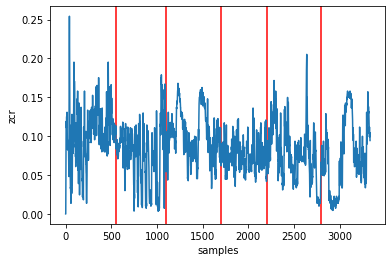

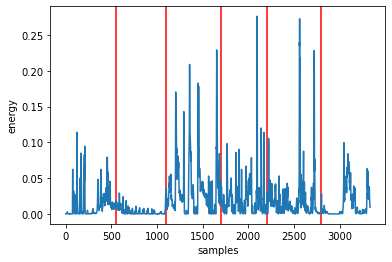

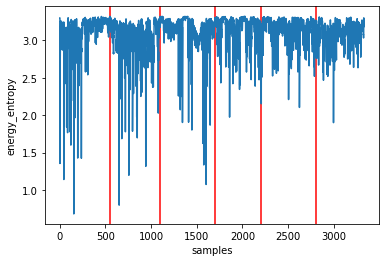

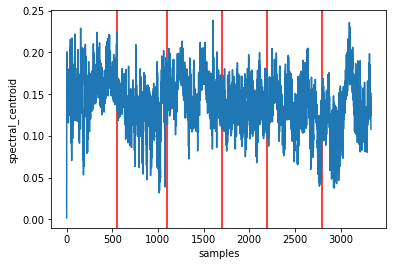

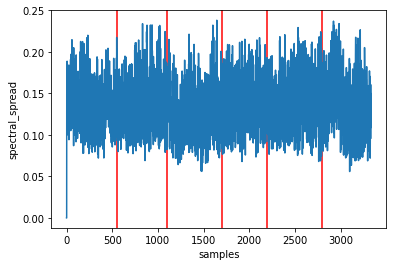

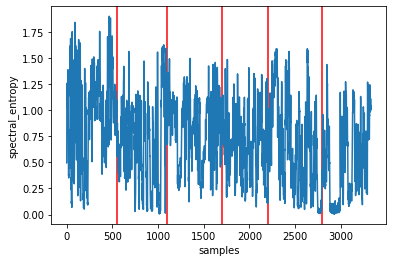

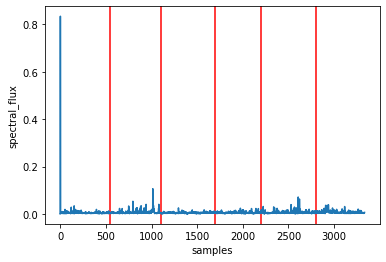

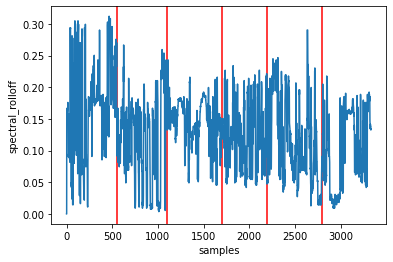

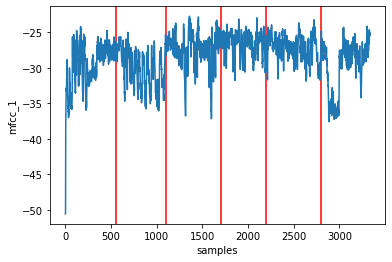

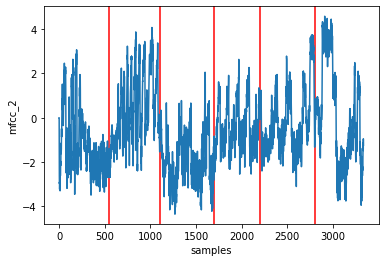

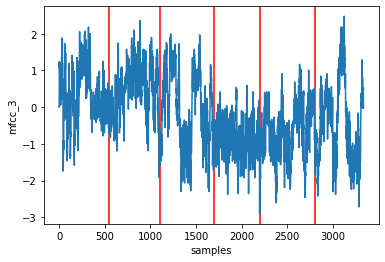

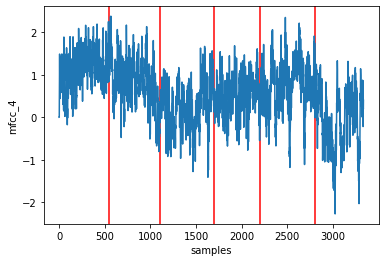

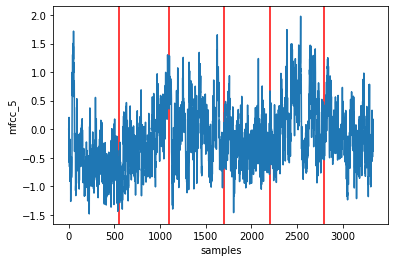

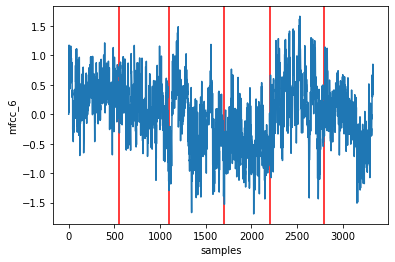

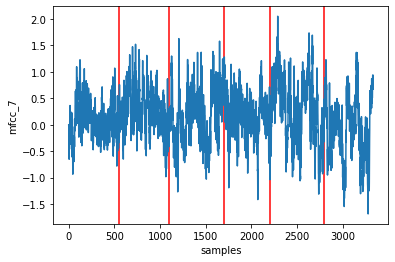

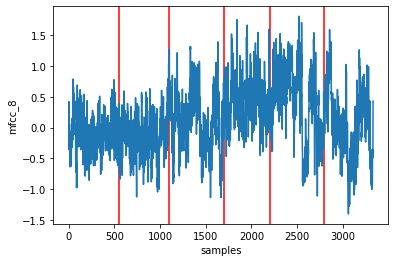

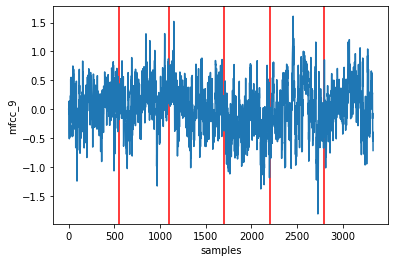

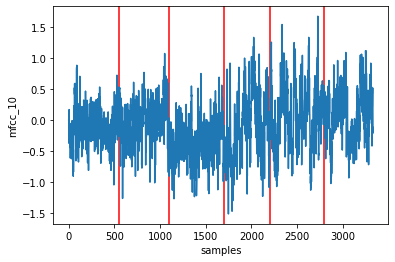

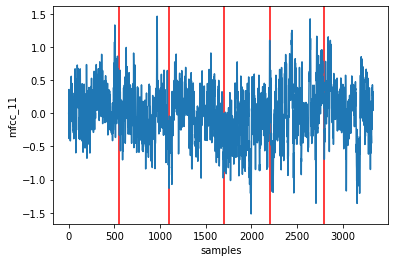

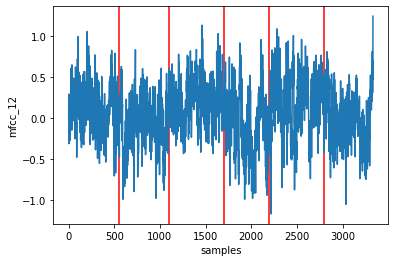

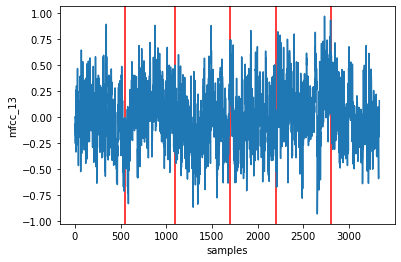

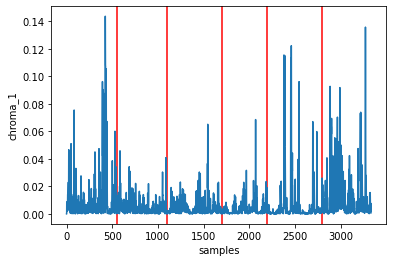

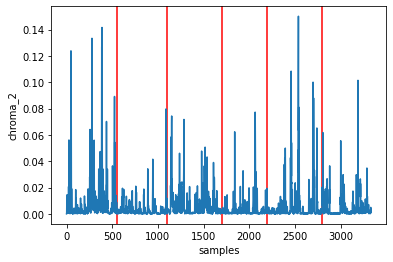

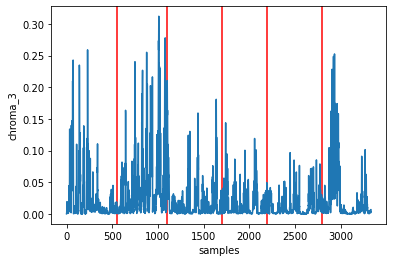

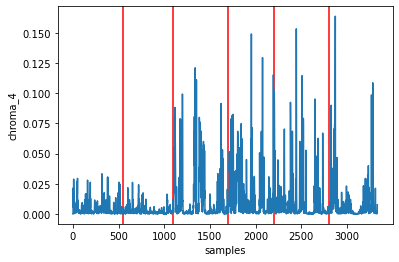

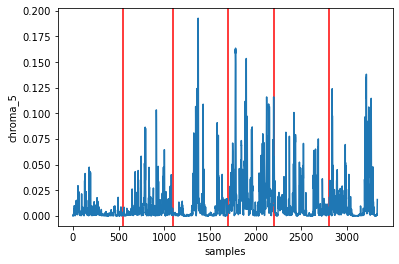

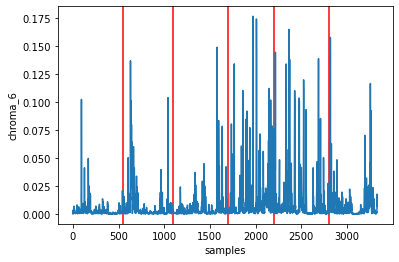

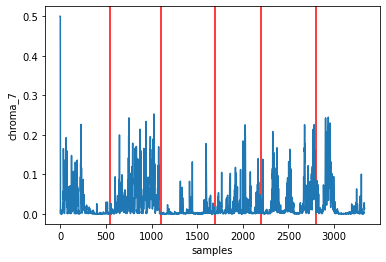

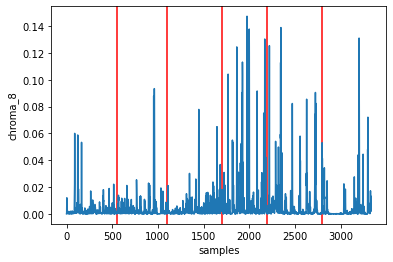

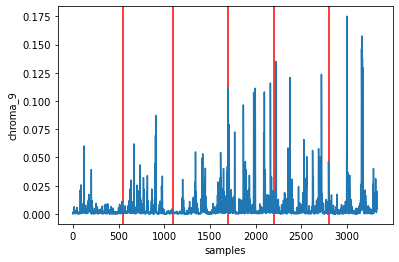

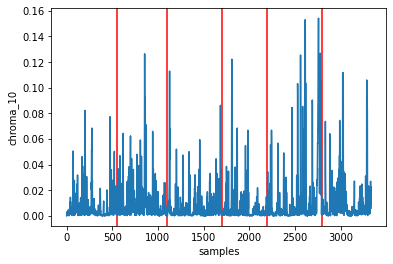

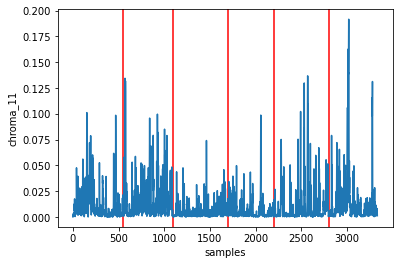

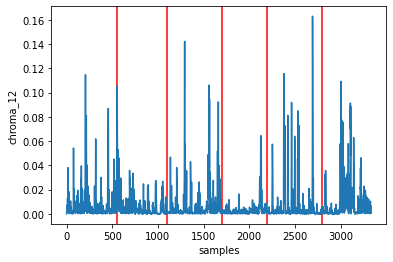

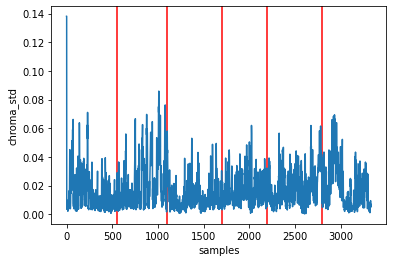

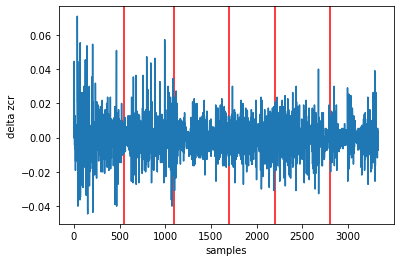

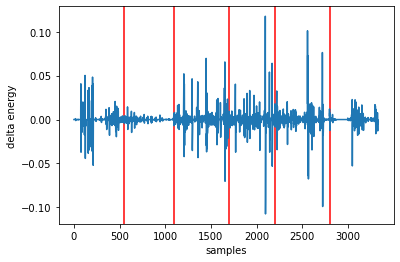

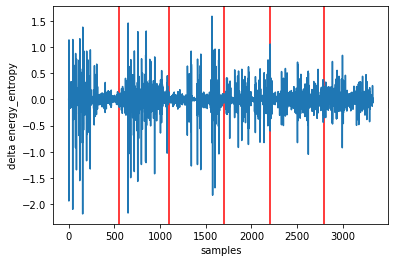

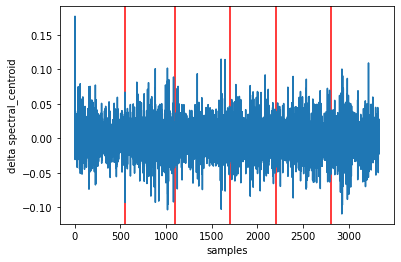

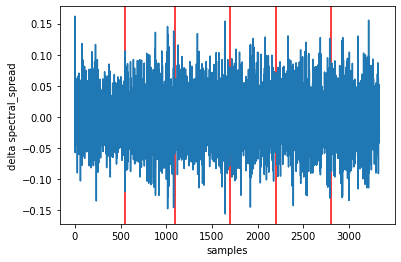

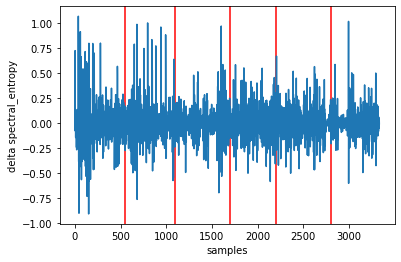

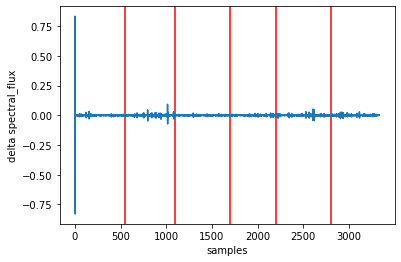

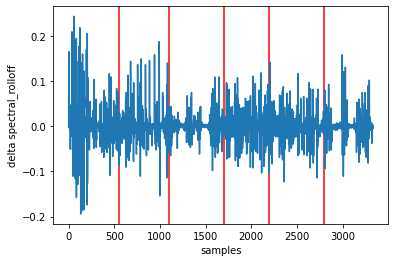

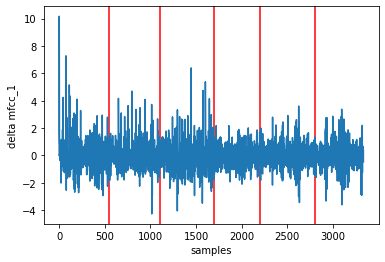

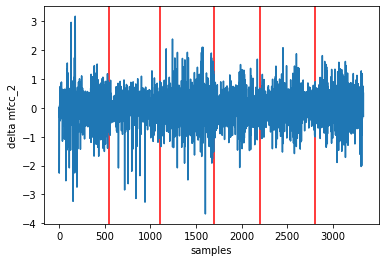

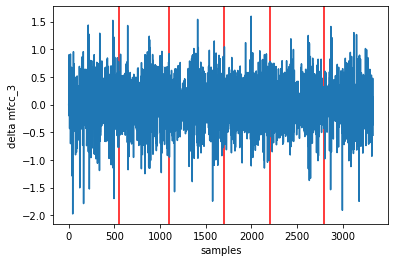

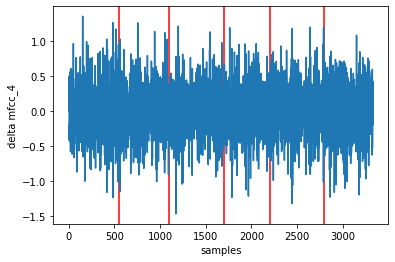

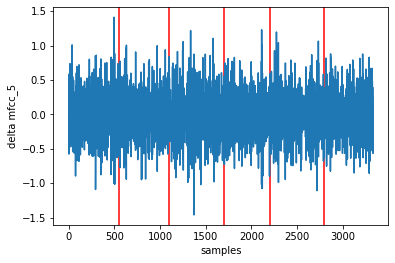

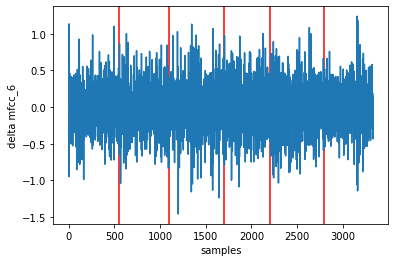

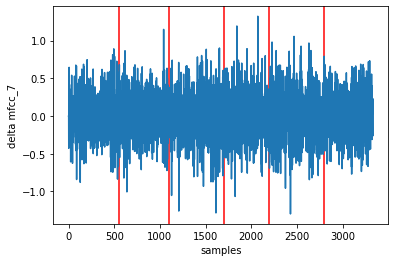

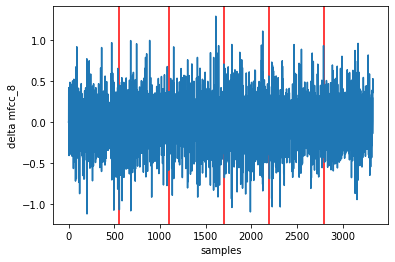

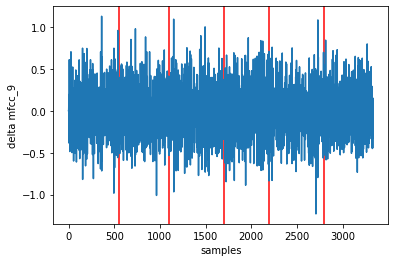

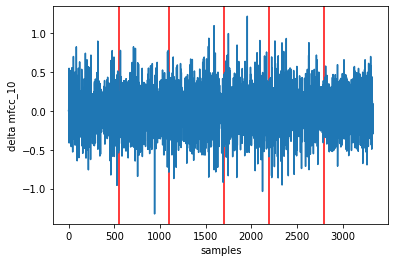

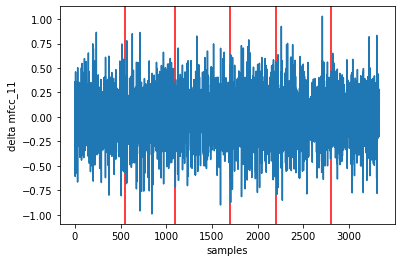

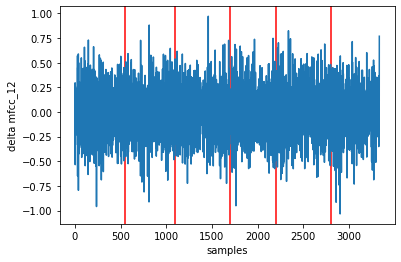

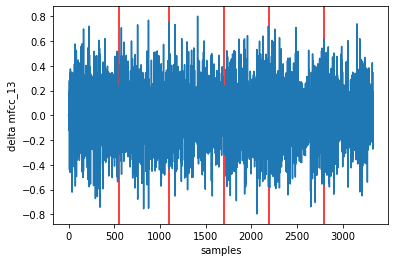

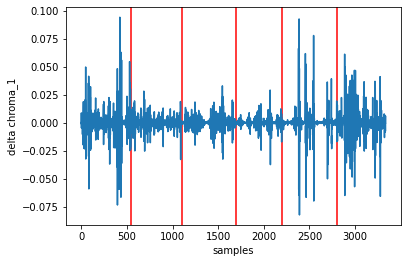

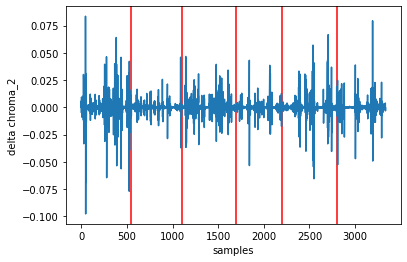

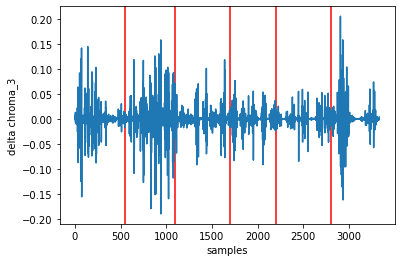

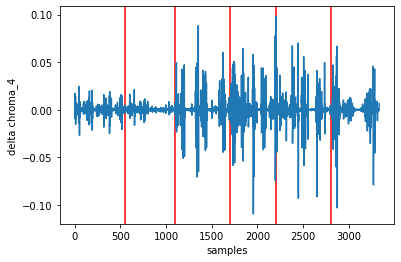

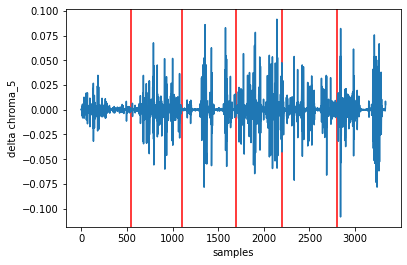

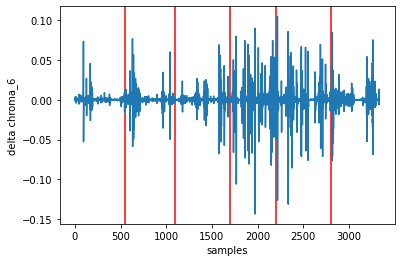

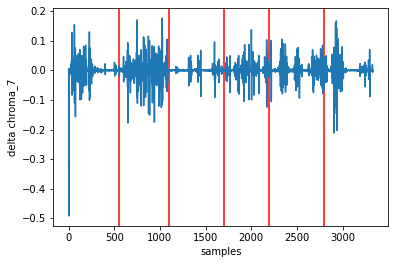

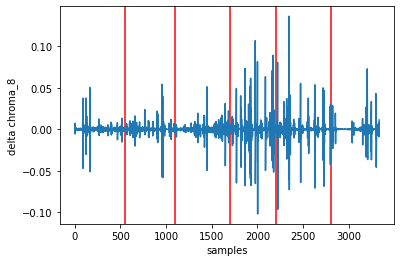

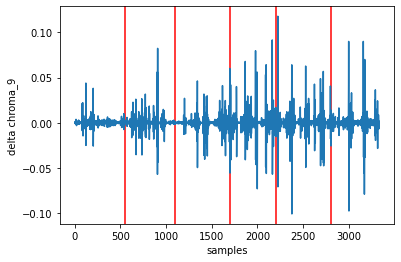

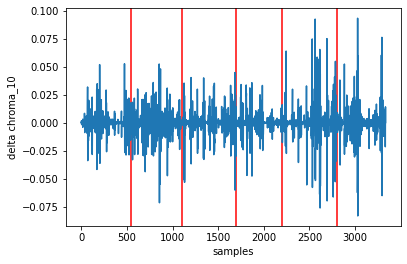

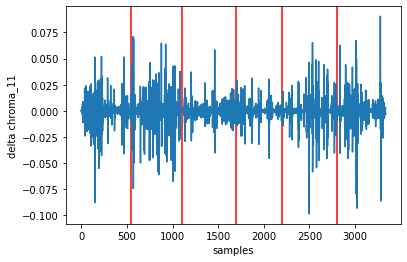

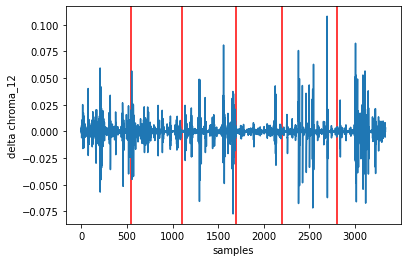

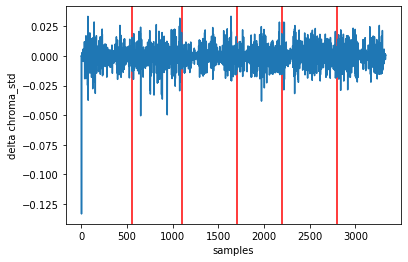

In [ ]:
for i in range(68):
  plt.figure(i)
  plt.xlabel("samples")
  plt.ylabel(f_names[i])
  plt.axvline(x = 550, ymin = 0, ymax = 1, 
            color ='red')
  plt.axvline(x = 1100, ymin = 0, ymax = 1, 
            color ='red')
  plt.axvline(x = 1700, ymin = 0, ymax = 1, 
            color ='red')
  plt.axvline(x = 2200, ymin = 0, ymax = 1, 
            color ='red')
  plt.axvline(x = 2800, ymin = 0, ymax = 1, 
            color ='red')
  plt.plot(data[i])